In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import ctime
import datetime as dt

In [8]:
os.getcwd()

'F:\\Downloads'

In [9]:
os.chdir(r'F://Downloads/')

In [10]:
# load data
transactions = pd.read_csv('transactions_prep.csv') #global
transactions['date'] = pd.to_datetime(transactions['date'])

In [16]:
# startDate = pd.Timestamp(dt.date(2012, 3, 2)) + dt.timedelta(4*7*0*1)
# endDate = startDate + dt.timedelta(4*7*2)
# startDate2 = endDate + dt.timedelta(1)
# endDate2 = startDate2 + dt.timedelta(14)

In [17]:
def preprocessing(startDate, endDate, startDate2, endDates):
    # endDates - массив с датами

    # Отбираем нужный временной период
    tempData = transactions[(transactions.date >= startDate) & (transactions.date <= endDate)] # global
    tempData.sales = tempData.sales.apply(lambda x: -x if x < 0 else x)
    
    RFM = pd.DataFrame() # Инициализация новой таблицы
    RFM['id'] = tempData.id.unique() # Список уникальных клиентов

    # добавить в RFM дату последней покупки
    RFM = RFM.merge(tempData.groupby('id', as_index=False)[['date']].last(), 
                left_on=['id'], right_on=['id']).rename(columns={'date':'last_date'})

    # recency
    maxdate = tempData.date.max()
    RFM['recency'] = RFM.last_date.apply(lambda x: (maxdate - x).days)

    # frequency
    frequency = (tempData.groupby('id').date.count() - 1).rename('frequency') 
    RFM = RFM.merge(pd.DataFrame(frequency),
                 left_on=['id'], right_on=['id']) 

    # monetary
    monetary = tempData.groupby('id')['sales'].sum().rename('monetary')
    RFM = RFM.merge(pd.DataFrame(monetary),
                 left_on=['id'], right_on=['id']) 

    # Ср время между покупками
    def func(a):
        return (a.date.iloc[-1] - a.date.iloc[0]).days / a.date.shape[0]

    av_time = tempData.groupby('id').apply(func).rename('average_time')
    RFM = RFM.merge(pd.DataFrame(av_time),
                    left_on=['id'], right_on=['id'])

    # ср цена товара в корзине и ср цена чека
    mean_sales = tempData.groupby('id')[['mean_sales', 'sales']].mean().rename(columns={'sales':'mean_sum_sales'})
    RFM = RFM.merge(mean_sales, left_on='id', right_on='id')

    # RFM.head(5)

    RFM.index = RFM.id
    RFM = RFM.drop('id', axis=1)
    
    # Рассчитываем CLTV
    for endDate2, T in zip(endDates, evalutionsPeriods):
        tempData = transactions[(transactions.date >= startDate2)&(transactions.date <= endDate2)]
        # Оставляем ID только тех клиентов, абсолютно новые клиенты, появившиеся в TestPeriod не учитываются
        newColName = 'CLTV_' + str(T)
        RFM = RFM.merge(tempData.groupby('id').sales.sum().rename(newColName),
                  right_on='id', left_on='id', how='left')
        RFM[newColName] = RFM[newColName].fillna(0) # CLTV=0 для тех, кто покупал на trainPeriod и не покупал на TestPeriod
    
    return RFM

In [18]:
def make_r(x):
    if x <= 2:
        return 1
    elif x <= 4: ######14
        return 2
    else:
        return 3

def make_f(x):
    if x <= 7:
        return 3
    elif x <= 14:
        return 2
    else:
        return 1


def make_m(x):
    if x <= 300:
        return 3
    elif x <= 1000:
        return 2
    else:
        return 1

def make_rfm(datas):
    datas['r'] = datas['recency'].apply(lambda x: make_r(x))
    datas['f'] = datas['frequency'].apply(lambda x: make_f(x))
    datas['m'] = datas['monetary'].apply(lambda x: make_m(x))
    datas['rfm_group'] = datas.apply(lambda x: str(x['r']) + str(x['f']) + str(x['m']), axis=1)

In [19]:
# create timelines

fitPeriod = 7*4*2 # Длина временного промежутка, на котором учимся # 8 недель #global
trainPeriods = [fitPeriod*i for i in range(0,3)] # Точки старта тренировочных периодов #global
evalutionsPeriods = [2, 4, 6, 8] # 2,4,6,8 недель на оценку LTV


# train
trainStartDate = [pd.Timestamp(dt.date(2012, 3, 2)) + dt.timedelta(period) for period in trainPeriods]
trainEndDate = [startDate + dt.timedelta(fitPeriod) for startDate in trainStartDate]

# test
testStartDate = [EndDate + dt.timedelta(1) for EndDate in trainEndDate]
testEndDate = [[startDate + dt.timedelta(7*period) for period in evalutionsPeriods] for startDate in testStartDate]

def make_data():
    start = 0
    for startDate, endDate, testStart,  testEnd in zip(trainStartDate, trainEndDate, testStartDate, testEndDate):
        RFM = preprocessing(startDate, endDate, testStart, testEnd)
        make_rfm(RFM)
        data = RFM.drop(columns=['last_date', 'r', 'f', 'm'])\
                  .sort_index().reset_index(drop=True)
        start += 1
        name = 'XY_' + str(start) + '.csv'
        data.to_csv(name, index=False)
        
        print(ctime() + '\t'+ name + ' сохранено.')

In [20]:
make_data()

Wed Oct 14 14:33:53 2020	XY_1.csv сохранено.
Wed Oct 14 14:34:13 2020	XY_2.csv сохранено.
Wed Oct 14 14:34:33 2020	XY_3.csv сохранено.


In [82]:
RFM.rfm_group.unique().shape

(27,)

<AxesSubplot:>

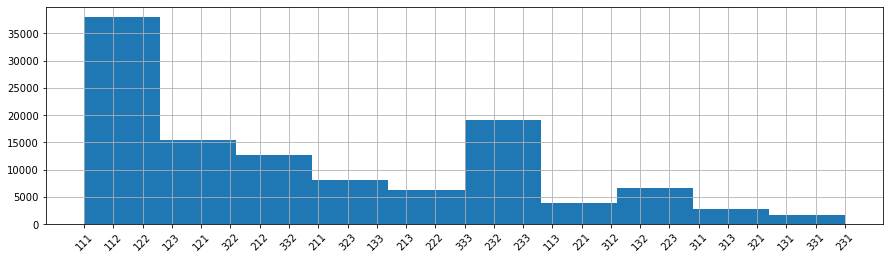

In [83]:
plt.subplots(1,1, figsize=(15,4))
RFM.rfm_group.hist(xrot=45)

(0.0, 9.0)

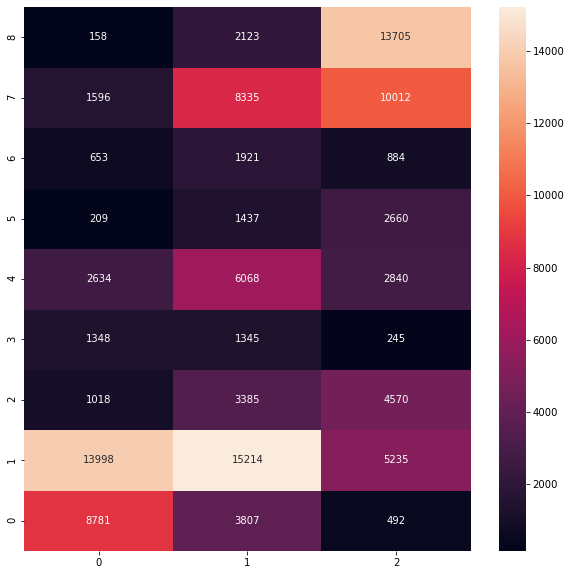

In [84]:
temp = [np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))]
for r in range(0,3):
    for m in range(0,3):
        for f in range(0,3):
            rfm_group = str(r+1) + str(f+1) + str(m+1)
            try:
                temp[r][m,f] = RFM.rfm_group.value_counts()[rfm_group]
#                 print(rfm_group + ' = ' + str(temp[r][m,f]))
            except:# KeyError:
                temp[r][f,m] = 0
a = np.vstack((temp[0], temp[1], temp[2]))

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.heatmap(a, annot=True, fmt='.0f')
ax.set_ylim([0,9])

In [616]:
a

array([[8.8080e+03, 9.0250e+03, 1.0362e+04],
       [3.0380e+03, 6.6060e+03, 1.4936e+04],
       [5.1700e+02, 1.8350e+03, 1.2844e+04],
       [5.2500e+02, 2.1060e+03, 6.8680e+03],
       [2.1200e+02, 1.3970e+03, 9.4140e+03],
       [4.3000e+01, 4.0200e+02, 8.9180e+03],
       [3.5000e+01, 2.0300e+02, 1.6370e+03],
       [2.1000e+01, 2.2400e+02, 4.6810e+03],
       [6.0000e+00, 1.0800e+02, 1.1351e+04]])

In [3]:
import numpy as np

In [5]:
temp = [np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))]
for r in range(0,3):
    for m in range(0,3):
        for f in range(0,3):
            rfm_group = str(r+1) + str(f+1) + str(m+1)
            try:
                temp[r][m,f] = rfm_group             
            except:# KeyError:
                pass
a = np.vstack((temp[0], temp[1], temp[2]))
a

array([[111., 121., 131.],
       [112., 122., 132.],
       [113., 123., 133.],
       [211., 221., 231.],
       [212., 222., 232.],
       [213., 223., 233.],
       [311., 321., 331.],
       [312., 322., 332.],
       [313., 323., 333.]])

F:\Anaconda3\envs\home\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


XY_1.csv


In [164]:
a = pd.read_csv('XY_1.csv')

In [165]:
a

,recency,frequency,monetary,average_time,mean_sales,mean_sum_sales,CLTV_2,CLTV_4,CLTV_6,CLTV_8,rfm_group
0,0,51,3853.29,1.076923,4.011320,74.101731,1195.98,1645.71,2393.58,3697.48,111
1,0,55,4385.84,1.000000,4.364518,78.318571,1241.67,2441.17,3090.19,4167.64,111
2,0,25,456.12,2.153846,4.254613,17.543077,187.67,322.28,438.49,677.46,112
3,0,19,398.88,2.800000,3.837531,19.944000,78.41,192.98,272.76,380.37,112
4,1,15,525.75,3.437500,4.221691,32.859375,100.37,211.69,306.33,416.33,112
...,...,...,...,...,...,...,...,...,...,...,...
114668,0,0,9.78,0.000000,3.260000,9.780000,0.00,0.00,10.27,19.85,133
114669,0,0,40.68,0.000000,10.170000,40.680000,0.00,0.00,0.00,0.00,133
114670,0,0,49.43,0.000000,3.089375,49.430000,0.00,61.06,109.68,168.92,133
114671,0,0,17.14,0.000000,1.714000,17.140000,0.00,0.00,0.00,0.00,133


In [152]:
RFM = preprocessing(startDate, endDate, testStart, testEnd)
make_rfm(RFM)

start = 0

for startDate, endDate, testStart, testEnds in zip(trainStartDate, trainEndDate, testStartDate, testEndDate):
    start += 1
    val_set = 0 # Для подписи
    for testEnd in testEnds:
        val_set += 1
        name = 'XY_' + str(start) + str(val_set) + '.csv'
        print(name)
#         RFM = preprocessing(startDate, endDate, testStart, testEnd)
#         make_rfm(RFM)
#         data = RFM.drop(columns=['last_date', 'r', 'f', 'm'])\
#                   .sort_index().reset_index(drop=True)
#         print(ctime(), '\ttestEnd\t', testEnd, ' посчитано.')
        #data.to_csv(name)

XY_11.csv
XY_12.csv
XY_13.csv
XY_14.csv
XY_21.csv
XY_22.csv
XY_23.csv
XY_24.csv
XY_31.csv
XY_32.csv
XY_33.csv
XY_34.csv


In [149]:
data

,recency,frequency,monetary,average_time,mean_sales,mean_sum_sales,CLTV,rfm_group
0,0,51,3853.29,1.076923,4.011320,74.101731,1195.98,111
1,0,55,4385.84,1.000000,4.364518,78.318571,1241.67,111
2,0,25,456.12,2.153846,4.254613,17.543077,187.67,112
3,0,19,398.88,2.800000,3.837531,19.944000,78.41,112
4,1,15,525.75,3.437500,4.221691,32.859375,100.37,112
...,...,...,...,...,...,...,...,...
114668,0,0,9.78,0.000000,3.260000,9.780000,0.00,133
114669,0,0,40.68,0.000000,10.170000,40.680000,0.00,133
114670,0,0,49.43,0.000000,3.089375,49.430000,0.00,133
114671,0,0,17.14,0.000000,1.714000,17.140000,0.00,133


In [119]:
# create timelines

fitPeriod = 7*4*2 # Длина временного промежутка, на котором учимся # 8 недель #global
trainPeriods = [fitPeriod*i for i in range(0,3)] # Точки старта тренировочных периодов #global
evalutionsPeriods = [2, 4, 6, 8] # 2,4,6,8 недель на оценку LTV


# train
trainStartDate = [pd.Timestamp(dt.date(2012, 3, 2)) + dt.timedelta(period) for period in trainPeriods]
trainEndDate = [startDate + dt.timedelta(fitPeriod) for startDate in trainStartDate]

# test
testStartDate = [EndDate + dt.timedelta(1) for EndDate in trainEndDate]
testEndDate = [[startDate + dt.timedelta(7*period) for period in evalutionsPeriods] for startDate in testStartDate]

for trainPeriod in trainPeriods:



RFM = preprocessing(startDate, endDate, startDate2, endDate2)
make_rfm(RFM)

for rfm in RFM.rfm_group.unique():
    # сформировать X and Y
    Xtrain = RFM[RFM.rfm_group == rfm].drop(columns=['last_date', 'r', 'f', 'm', 'rfm_group', 'CLTV'])\
                                      .sort_index().reset_index(drop=True)
    ytrain = RFM[RFM.rfm_group == rfm][['CLTV']].sort_index().reset_index(drop=True)

In [21]:
ytrain.values

array([1195.98, 1241.67,  319.12, ...,  382.62,   92.  ,  414.07])

In [40]:
transactions[transactions.sales <= 0].id.unique()

array([   113,    214,    302, ..., 106338, 106390, 108122], dtype=int64)

In [41]:
transactions.id.unique().shape

(116925,)

In [57]:
transactions[(transactions.date >= startDate)&(transactions.date <= endDate)].groupby('id').sales.sum().min()

-1347.9799999999996

In [42]:
transactions[transactions.id == 113]

,date,id,mean_sales,sales
112,2012-03-02,113,-4.950000,-4.95
972363,2012-04-10,113,8.355455,183.82
1212238,2012-04-20,113,5.735000,11.47
1410794,2012-04-28,113,8.738235,297.10
1644425,2012-05-07,113,12.232500,48.93
1716352,2012-05-10,113,15.980000,15.98
1825544,2012-05-14,113,18.780000,37.56
1949303,2012-05-19,113,6.669706,226.77
2078349,2012-05-24,113,5.307143,74.30
2494661,2012-06-09,113,6.126207,355.32


In [23]:
import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [24]:
modelLinReg = LinearRegression()
modelLinReg.fit(Xtrain, ytrain)

# modelRF = RandomForestRegressor(max_depth=10, n_estimators=100)
# modelRF.fit(Xtrain, ytrain)

# modelGrBoost = GradientBoostingRegressor()
# modelGrBoost.fit(Xtrain, ytrain)

# # stacking
# class custommodel:
#     def __init__(self, *args):
#         self.models = args
#     def predict(self, x):
#         return np.array([m.predict(x) for m in self.models[0]]).mean(axis=0) # смешаем в пропорции 50/50
    
# _ = custommodel([modelRF, modelGrBoost])

# # Мешок моделей
# bagWithModels = {'model_name':('LinReg', 'RF', 'GrBoost', 'RF+GrBoost'),  
#                 'models': (modelLinReg, modelRF, modelGrBoost, _)}

LinearRegression()

In [25]:
_.predict(Xtrain)

array([2467.44579187, 2911.07312402,  603.29102224, ..., -200.43776753,
       -436.20491041, -376.33724697])

In [51]:
ytrain.min()

0.0

In [49]:
vfunc(modelLinReg.predict(Xtrain))[vfunc(modelLinReg.predict(Xtrain))<1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.82496648, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1196632 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [50]:
np.log(0.82+1)

0.5988365010887039

In [65]:
# Некоторые модели предсказывают отрицательные LTV
# Поэтому в таких предсказаниях нужно заменять отрицательные значения на ноль

def func(x):
    return x if x>=0 else 0
vfunc = np.vectorize(func)

# RMSLE function

def rmsle(ytrue, ypred):
    '''
    Parameters:
    -------
        ytrue, ypred: pandas.Series or  numpy.array
    
    Returns
    -------
    float
    '''
    return np.sqrt(((np.log(ypred + 1) - np.log(ytrue + 1))**2).mean())


In [66]:
rmsle(vfunc(ytrain), modelLinReg.predict(Xtrain))

<ipython-input-65-c58127081623>:20: RuntimeWarning: invalid value encountered in log
  return np.sqrt(((np.log(ypred + 1) - np.log(ytrue + 1))**2).mean())


nan

In [708]:
rmsle(vfunc(ytrain.values.ravel()), vfunc(modelLinReg.predict(Xtrain)))

1.0173295992869897

In [709]:
vfunc(modelGrBoost.predict(Xtrain))

array([510.20454087, 733.87557567, 355.59404877, ..., 279.03890235,
       380.85262274, 309.76073669])

In [703]:
vfunc(ytrain.values.ravel())

array([ 543.19, 1026.71,  554.39, ...,  217.13,  300.25,  325.61])

In [696]:
ytrain.values.ravel()

array([ 543.19, 1026.71,  554.39, ...,  217.13,  300.25,  325.61])

In [694]:
modelRF.predict(Xtrain)

array([544.17632359, 745.4260377 , 356.20307172, ..., 278.01084713,
       384.890547  , 316.64951246])

In [ ]:




def fastEval(model, x, y):
    '''Обучения и метрика быстро, для отладки'''
    model.fit(x,y)
    y_pr = vfunc(model.predict(x))
    return rmsle(y, y_pr)

metrics = (rmsle, mean_absolute_error, r2_score)
metric_names = ('RMSLE', 'MAE', 'R2')
yTrues = (yTrue_train, yTrue_test, yTrue_val)
_names = ('_train', '_test', '_val')
X = (Xtrain, Xtest, Xval)

shape = (len(bagWithModels['model_name']), len(metric_names)*len(_names)) #(rows, cols)
summary = pd.DataFrame(np.zeros(shape).reshape(shape), 
             columns=[mn+n for mn in metric_names for n in _names],
             index=bagWithModels['model_name'])

# Для каждой модели вычисляем метрики на train, test, val
for model, model_name in zip(bagWithModels['models'], bagWithModels['model_name']):
    for metric, metric_name in zip(metrics, metric_names):
        for yTrue, x, _name in zip(yTrues, X, _names):
            print(model_name, _name)
            yPred = vfunc(model.predict(x)) # Делаем предсказание !vfunc!
            summary.loc[model_name][metric_name+_name] = metric(yTrue, yPred) # Вычисляем метрику

In [57]:
Xtrain = transactions[transactions.date < trainEndDate] # train

In [62]:
y_train = Xtrain.groupby('id').sales.sum().rename('CLTV') # Строка Y которую надо предсказать для каждого клиента

In [63]:
ltv_train = y_train.sum() # Сумма всех LTV общая

In [67]:
Xtrain

,date,id,chain,mean_sales,sales,month,day_of_week,day,year,dataType
0,2012-03-02,1,205,4.048269,210.51,3,4,2,2012,0
1,2012-03-02,2,205,4.049118,137.67,3,4,2,2012,0
2,2012-03-02,3,95,2.437273,26.81,3,4,2,2012,0
3,2012-03-02,4,4,5.140000,15.42,3,4,2,2012,0
4,2012-03-02,5,18,8.870000,8.87,3,4,2,2012,0
...,...,...,...,...,...,...,...,...,...,...
48752,2012-04-26,605,15,3.990000,3.99,4,6,22,2012,2
48753,2012-04-26,559,17,4.907500,39.26,4,6,22,2012,2
48754,2012-04-26,576,15,8.226000,41.13,4,6,22,2012,2
48755,2012-04-26,561,95,2.802000,28.02,4,6,22,2012,2


In [66]:
data = transactions.sort_values(by=['date', 'id'])

In [67]:
data = transactions.sort_values(by=['date', 'id'])
RFM = pd.DataFrame()
RFM['id'] = data.id.unique() # Список уникальных клиентов
# добавить в RFM дату последней покупки
RFM = RFM.merge(data.groupby('id', as_index=False)[['date']].last(), left_on=['id'], right_on=['id'])

# recency
maxdate = data.date.max()
RFM['recency'] = RFM.date.apply(lambda x: (maxdate - x).days)

# frequency
frequency = data.groupby('id').apply(lambda x: x.shape[0]).rename('frequency') 
RFM = RFM.merge(pd.DataFrame(frequency),
                left_on=['id'], right_on=['id']) 

# monetary
monetary = data.groupby('id')['sales'].sum().rename('monetary')
RFM = RFM.merge(pd.DataFrame(monetary),
                left_on=['id'], right_on=['id']) 

# Ср время между покупками
def func(a):
    return (a.date.iloc[-1] - a.date.iloc[0]).days / a.date.shape[0]

av_time = data.groupby('id').apply(func).rename('average_time')
# monetary = data.groupby('id')['sales'].sum().rename('monetary')
RFM = RFM.merge(pd.DataFrame(av_time),
                left_on=['id'], right_on=['id'])

RFM.head(5)

,id,date,recency,frequency,monetary,average_time
0,1,2013-04-23,7,381,52828.12,1.094488
1,2,2013-03-26,35,368,53592.90,1.057065
2,3,2013-04-30,0,203,3581.86,2.088670
3,4,2013-04-27,3,143,3317.97,2.944056
4,5,2013-03-21,40,141,3383.84,2.723404


In [69]:
RFM

,id,date,recency,frequency,monetary,average_time
0,1,2013-04-23,7,381,52828.12,1.094488
1,2,2013-03-26,35,368,53592.90,1.057065
2,3,2013-04-30,0,203,3581.86,2.088670
3,4,2013-04-27,3,143,3317.97,2.944056
4,5,2013-03-21,40,141,3383.84,2.723404
...,...,...,...,...,...,...
607,503,2013-03-30,31,18,953.40,8.777778
608,611,2013-04-30,0,45,1363.44,3.266667
609,504,2013-04-20,10,22,1496.46,5.590909
610,612,2013-04-25,5,22,1409.49,5.727273


In [85]:
idx = RFM.index

In [86]:
idx

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            602, 603, 604, 605, 606, 607, 608, 609, 610, 611],
           dtype='int64', length=612)

In [8]:
def make_r(x):
    if x <= 3:
        return 1
    elif x <= 10: ######14
        return 2
    else:
        return 3

def make_f(x):
    if x <= 8:
        return 3
    elif x <= 12:
        return 2
    else:
        return 1


def make_m(x):
    if x <= 500:
        return 3
    elif x <= 1500:
        return 2
    else:
        return 1

def make_rfm(datas):
    datas['r'] = datas['recency'].apply(lambda x: make_r(x))
    datas['f'] = datas['frequency'].apply(lambda x: make_f(x))
    datas['m'] = datas['monetary'].apply(lambda x: make_m(x))
    datas['rfm_group'] = datas.apply(lambda x: str(x['r']) + str(x['f']) + str(x['m']), axis=1)

In [9]:
make_rfm(RFM)
RFM.head(3)

,id,date,recency,frequency,monetary,average_time,r,f,m,rfm_group
0,1,2012-04-26,0,51,3813.96,1.078431,1,1,1,111
1,2,2012-04-26,0,55,4348.78,1.000000,1,1,1,111
2,3,2012-04-26,0,25,445.35,2.200000,1,1,3,113


In [10]:
temp = [np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3))]
for r in range(0,3):
    for m in range(0,3):
        for f in range(0,3):
            rfm_group = str(r+1) + str(f+1) + str(m+1)
            try:
                temp[r][m,f] = RFM.rfm_group.value_counts()[rfm_group]                
            except:# KeyError:
                temp[r][m,f] = 0
a = np.vstack((temp[0], temp[1], temp[2]))

| R | F | M | 
| - | - | - |
|111|112|113|
|121|122|123|
|131|132|133|
| - | - | - |
|211|212|213|
|221|222|223|
|231|232|233|
| - | - | - |
|311|312|313|
|321|322|323|
|331|332|333|


'\n111 | \n'

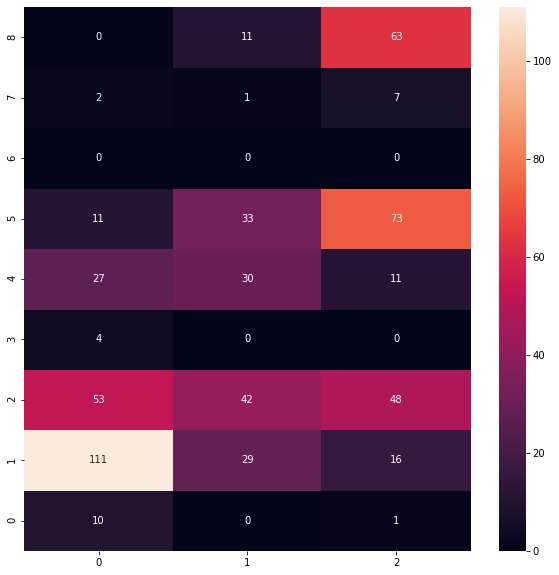

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.heatmap(a, annot=True, fmt='.0f')
ax.set_ylim([0,9])

'''
111 | 
'''

In [12]:
# create train, test, val datasets
# train
train = transactions[transactions.date < trainEndDate]
trainEval = transactions[(transactions.date >= trainEndDate)&(transactions.date <= traineEvaluateDate)]
# test
test = transactions[(transactions.date >= testStartDate)&(transactions.date < testEndDate)]
testEval = transactions[(transactions.date >= testEndDate)&(transactions.date <= testEvaluateDate)]
# val
val = transactions[(transactions.date >= valStartDate)&(transactions.date < valEndDate)]
valEval = transactions[(transactions.date >= valEndDate)&(transactions.date <= valEvaluateDate)]

for i in [train, trainEval, test, testEval, val, valEval]: print(i.shape)

(7081, 9)
(2063, 9)
(7655, 9)
(2018, 9)
(7456, 9)
(2028, 9)


In [13]:
# Вычисление целевой перменной - сумма дохода за период по каждому клиенту

def make_y_true(train, test):
    '''
    Parameters:
    -------
        train, test: pandas.DataFrame with columns: cust,sales
    
    Returns
    -------
    pandas.Series
    
    '''
    test = test.groupby('id').sales.sum().rename('test')
    var1 = train.groupby('id').sum().rename(columns={'sales':'train'})
    # Учитываем в test только тех клиентов, которые есть в train
    var2 = var1.merge(pd.DataFrame(test), left_on='id', right_on='id', how='left') 
    var2.test = var2.test.apply(lambda x: x if x>0 else 0)
    y_true = var2.test
   
    return y_true

# CLTV really
yTrue_train = make_y_true(train, trainEval)
yTrue_test = make_y_true(test, testEval)
yTrue_val = make_y_true(val, valEval)

In [14]:
# Блок для вычисления признаков клиентов по transaction log

def shift_date(x): 
    # посмотрим на смещение во времени, через сколько была следующая покупка
    x['shifted_date'] = x['date'].shift(-1) 
    return x



def compute_rfm(x, end_calibration):
    # функция на весь RFM
    x['recency'] = (x['date'].max() - x['date'].min()).days
    x['frequency'] = x['date'].count()-1
    x['T'] = (end_calibration - x['date'].min()).days
    x['monetary_value'] = x['sales'].mean()
    return x

def make_x(transactions, end_calibration):

    # Вычисляем М параметр на покупателя и дату

    train2 = transactions.sort_values(['date'], ascending=True)\
              .groupby(['id', 'date'], 
                        as_index=False)['sales'].sum()    
    # RFM
    train3 = train2.groupby(['id']).apply(lambda x: compute_rfm(x, end_calibration))
    # отбираем 1 строку, которая показывает агрегированные данные пользователя
    rfm = train3[['id', 'recency', 'frequency', 'T', 'monetary_value']].groupby(['id']).first()
    
    return rfm

In [15]:
Xtrain = make_x(train, trainEndDate)
Xtest = make_x(test, testEndDate)
Xval = make_x(val, valEndDate)

In [16]:
for i,j in ((Xtrain, yTrue_train), (Xtest, yTrue_test), (Xval, yTrue_val)):
            print(i.shape, j.shape)

(583, 4) (583,)
(587, 4) (587,)
(591, 4) (591,)


In [17]:
# Xtrain.to_csv('Xtrain.csv')
# Xtest.to_csv('Xtest.csv')
# Xval.to_csv('Xval.csv')

# yTrue_train.to_csv('yTrue_train.csv')
# yTrue_test.to_csv('yTrue_test.csv')
# yTrue_val.to_csv('yTrue_val.csv')

In [18]:
import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [26]:
modelLinReg = LinearRegression()
modelLinReg.fit(Xtrain, yTrue_train)

modelRF = RandomForestRegressor(max_depth=10, n_estimators=100)
modelRF.fit(Xtrain, yTrue_train)

modelGrBoost = GradientBoostingRegressor()
modelGrBoost.fit(Xtrain, yTrue_train)

# stacking
class custommodel:
    def __init__(self, *args):
        self.models = args
    def predict(self, x):
        return np.array([m.predict(x) for m in self.models[0]]).mean(axis=0) # смешаем в пропорции 50/50
    
_ = custommodel([modelRF, modelGrBoost])

# Мешок моделей
bagWithModels = {'model_name':('LinReg', 'RF', 'GrBoost', 'RF+GrBoost'),  
                'models': (modelLinReg, modelRF, modelGrBoost, _)}

# Некоторые модели предсказывают отрицательные LTV
# Поэтому в таких предсказаниях нужно заменять отрицательные значения на ноль

def func(x):
    return x if x>=0 else 0
vfunc = np.vectorize(func)

# RMSLE function

def rmsle(ytrue, ypred):
    '''
    Parameters:
    -------
        ytrue, ypred: pandas.Series or  numpy.array
    
    Returns
    -------
    float
    '''
    return np.sqrt(((np.log(ypred + 1) - np.log(ytrue + 1))**2).mean())

def fastEval(model, x, y):
    '''Обучения и метрика быстро, для отладки'''
    model.fit(x,y)
    y_pr = vfunc(model.predict(x))
    return rmsle(y, y_pr)

metrics = (rmsle, mean_absolute_error, r2_score)
metric_names = ('RMSLE', 'MAE', 'R2')
yTrues = (yTrue_train, yTrue_test, yTrue_val)
_names = ('_train', '_test', '_val')
X = (Xtrain, Xtest, Xval)

shape = (len(bagWithModels['model_name']), len(metric_names)*len(_names)) #(rows, cols)
summary = pd.DataFrame(np.zeros(shape).reshape(shape), 
             columns=[mn+n for mn in metric_names for n in _names],
             index=bagWithModels['model_name'])

# Для каждой модели вычисляем метрики на train, test, val
for model, model_name in zip(bagWithModels['models'], bagWithModels['model_name']):
    for metric, metric_name in zip(metrics, metric_names):
        for yTrue, x, _name in zip(yTrues, X, _names):
            print(model_name, _name)
            yPred = vfunc(model.predict(x)) # Делаем предсказание !vfunc!
            summary.loc[model_name][metric_name+_name] = metric(yTrue, yPred) # Вычисляем метрику

In [27]:
# Мешок моделей
bagWithModels = {'model_name':('LinReg', 'RF', 'GrBoost', 'RF+GrBoost'),  
                'models': (modelLinReg, modelRF, modelGrBoost, _)}

In [28]:
# Некоторые модели предсказывают отрицательные LTV
# Поэтому в таких предсказаниях нужно заменять отрицательные значения на ноль

def func(x):
    return x if x>=0 else 0
vfunc = np.vectorize(func)

In [29]:
# RMSLE function

def rmsle(ytrue, ypred):
    '''
    Parameters:
    -------
        ytrue, ypred: pandas.Series or  numpy.array
    
    Returns
    -------
    float
    '''
    return np.sqrt(((np.log(ypred + 1) - np.log(ytrue + 1))**2).mean())

def fastEval(model, x, y):
    '''Обучения и метрика быстро, для отладки'''
    model.fit(x,y)
    y_pr = vfunc(model.predict(x))
    return rmsle(y, y_pr)

In [30]:
metrics = (rmsle, mean_absolute_error, r2_score)
metric_names = ('RMSLE', 'MAE', 'R2')
yTrues = (yTrue_train, yTrue_test, yTrue_val)
_names = ('_train', '_test', '_val')
X = (Xtrain, Xtest, Xval)

shape = (len(bagWithModels['model_name']), len(metric_names)*len(_names)) #(rows, cols)
summary = pd.DataFrame(np.zeros(shape).reshape(shape), 
             columns=[mn+n for mn in metric_names for n in _names],
             index=bagWithModels['model_name'])

# Для каждой модели вычисляем метрики на train, test, val
for model, model_name in zip(bagWithModels['models'], bagWithModels['model_name']):
    for metric, metric_name in zip(metrics, metric_names):
        for yTrue, x, _name in zip(yTrues, X, _names):
            print(model_name, _name)
            yPred = vfunc(model.predict(x)) # Делаем предсказание !vfunc!
            summary.loc[model_name][metric_name+_name] = metric(yTrue, yPred) # Вычисляем метрику

LinReg _train
LinReg _test
LinReg _val
LinReg _train
LinReg _test
LinReg _val
LinReg _train
LinReg _test
LinReg _val
RF _train
RF _test
RF _val
RF _train
RF _test
RF _val
RF _train
RF _test
RF _val
GrBoost _train
GrBoost _test
GrBoost _val
GrBoost _train
GrBoost _test
GrBoost _val
GrBoost _train
GrBoost _test
GrBoost _val
RF+GrBoost _train
RF+GrBoost _test
RF+GrBoost _val
RF+GrBoost _train
RF+GrBoost _test
RF+GrBoost _val
RF+GrBoost _train
RF+GrBoost _test
RF+GrBoost _val


In [31]:
summary

,RMSLE_train,RMSLE_test,RMSLE_val,MAE_train,MAE_test,MAE_val,R2_train,R2_test,R2_val
LinReg,1.419206,1.472888,1.415866,72.321979,77.293607,73.358120,0.461650,0.356753,0.449478
RF,1.047882,1.491392,1.366165,33.919632,80.295640,70.400244,0.898494,0.382384,0.476448
GrBoost,1.184617,1.449327,1.373294,47.802109,77.267970,69.568378,0.796658,0.394018,0.485650
RF+GrBoost,1.117851,1.465603,1.366318,40.292806,78.248380,69.066046,0.859040,0.402693,0.495606
